In [1]:
import os
import rasterio
import numpy as np
import pandas as pd
from collections import defaultdict

In [2]:
pasta = "../input_data/01_lulc/lulc_data"
arquivos = [f for f in os.listdir(pasta) if f.startswith("land_use_30m_") and f.endswith(".tif")]
arquivos_lulc = [f for f in os.listdir(pasta) if f.startswith("land_use_30m_") and f.endswith(".geojson")]

## PARA TODA BACIA HIDROGRÁFICA

In [5]:
resultados = []
for arquivo in arquivos:
    ano = arquivo.split("_")[-1].replace(".tif", "")
    caminho_completo = os.path.join(pasta, arquivo)
    with rasterio.open(caminho_completo) as src:
        dados = src.read(1)
        classes, contagens = np.unique(dados[~np.isnan(dados)], return_counts=True)
        for classe, contagem in zip(classes, contagens):
            area_ha = contagem * 0.09
            resultados.append({
                "ano": ano,
                "classe": int(classe),
                "count": int(contagem),
                "area_ha": area_ha
            })

df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados[df_resultados.classe != 0].reset_index(drop=True)
df_resultados = df_resultados.sort_values(by=["ano", "classe"])

#df_resultados.to_csv("areas_por_classe_lulc_1985-2024.csv", index=False)
print(df_resultados.head())

      ano  classe   count   area_ha
120  1985       3   96080   8647.20
121  1985       4  728019  65521.71
122  1985       9     130     11.70
123  1985      11    9614    865.26
124  1985      12   31293   2816.37


In [6]:
area_total_por_ano = df_resultados.groupby('ano')['area_ha'].transform('sum')
df_resultados['area_percent'] = round((df_resultados['area_ha'] / area_total_por_ano) * 100, 2)
df_resultados = df_resultados.sort_values(['ano', 'classe'])
display(df_resultados.head(10))

,ano,classe,count,area_ha,area_percent
120,1985,3,96080,8647.20,7.83
121,1985,4,728019,65521.71,59.29
122,1985,9,130,11.70,0.01
123,1985,11,9614,865.26,0.78
124,1985,12,31293,2816.37,2.55
125,1985,15,36410,3276.90,2.97
126,1985,21,53673,4830.57,4.37
127,1985,24,117693,10592.37,9.59
128,1985,25,92071,8286.39,7.50
129,1985,33,59081,5317.29,4.81


In [7]:
df_resultados.classe.unique()

array([ 3,  4,  9, 11, 12, 15, 21, 24, 25, 33, 39, 41, 46, 48])

In [13]:
lulc_name = pd.read_excel('../input_data/01_lulc/codigos-da-legenda-colecao-9.xlsx').rename(columns = {"Nivel ": "Nivel"})

In [9]:
type(lulc_name.loc[0,"Class_ID"])

numpy.int64

In [10]:
lulc_data = lulc_name[["Class_ID", "Nivel", "Descricao"]].merge(df_resultados, left_on = "Class_ID", right_on = "classe")#[["Nivel", "ano", "area_ha", "area_percent"]] # "Descricao"

In [11]:
print(sorted(lulc_data.Nivel.unique()))
lulc_data['Nivel'] = lulc_data['Nivel'].replace([ 'Agricultura', 'Mosaico de Usos', 'Pastagem', 'Silvicultura'], 'Agropecuária')
print(sorted(lulc_data.Nivel.unique()))

['Agricultura', "Corpo D'Água", 'Floresta', 'Mosaico de Usos', 'Pastagem', 'Silvicultura', 'Vegetação Herbácea e Arbustiva', 'Área não Vegetada']
['Agropecuária', "Corpo D'Água", 'Floresta', 'Vegetação Herbácea e Arbustiva', 'Área não Vegetada']


In [12]:
lulc_data = lulc_data.groupby(['Nivel', 'ano'], as_index=False).agg({'area_ha': 'sum', 'area_percent': 'sum'})

In [13]:
lulc_data[lulc_data.ano == "1985"]

,Nivel,ano,area_ha,area_percent
0,Agropecuária,1985,8458.11,7.66
40,Corpo D'Água,1985,5317.29,4.81
80,Floresta,1985,74168.91,67.12
120,Vegetação Herbácea e Arbustiva,1985,3681.63,3.33
160,Área não Vegetada,1985,18878.76,17.09


In [23]:
lulc_data[lulc_data.ano == "2024"]

,Nivel,Color,ano,area_ha,area_percent
39,Floresta,#32a65e,2024,62050.95,56.15
79,Vegetação Herbácea e Arbustiva,#ad975a,2024,2147.94,1.95
119,Agropecuária,#FFFFB2,2024,10109.52,9.15
159,Área não Vegetada,#d4271e,2024,31322.70,28.34
199,Corpo D'Água,#0000FF,2024,4873.59,4.41


In [14]:
lulc_data = lulc_name[lulc_name.Level == 1][["Nivel", "Color"]].merge(lulc_data, on = "Nivel")

In [15]:
print(sorted(lulc_data.Nivel.unique()))


['Agropecuária', "Corpo D'Água", 'Floresta', 'Vegetação Herbácea e Arbustiva', 'Área não Vegetada']


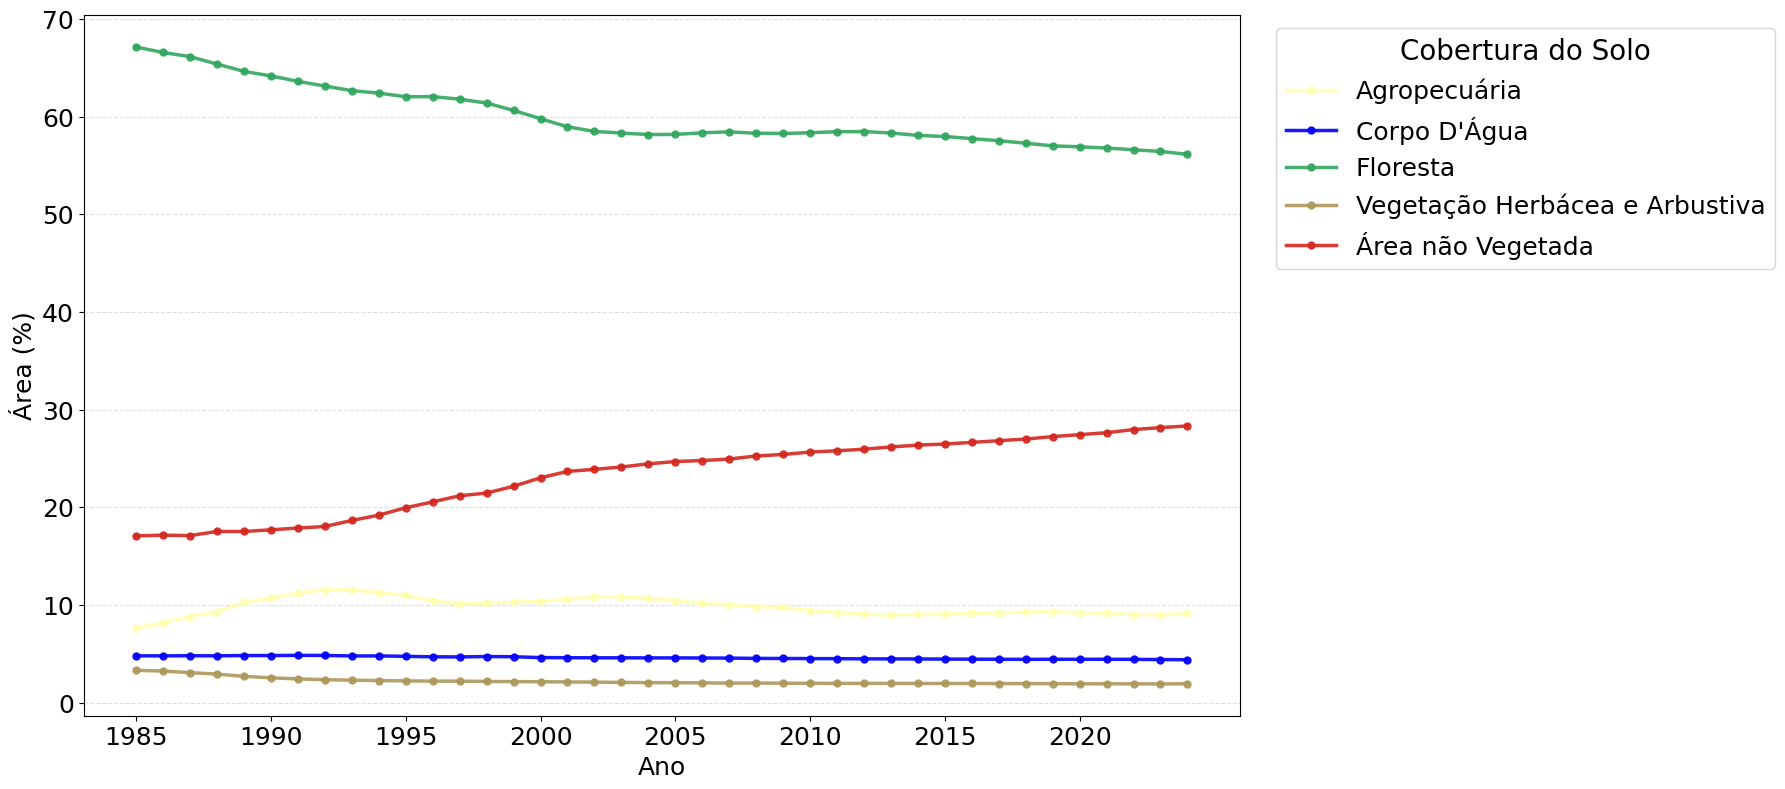

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data
df_plot = lulc_data.groupby(['ano', 'Nivel', 'Color'])['area_percent'].mean().reset_index()

# Create figure with larger size
plt.figure(figsize=(18, 8))

# Plot each land cover type
for nivel in df_plot['Nivel'].unique():
    subset = df_plot[df_plot['Nivel'] == nivel]
    cor = subset['Color'].iloc[0]  
    plt.plot(subset['ano'], subset['area_percent'], 
             marker='o', 
             markersize=5,  # Slightly larger markers
             label=f'{nivel}', 
             color=cor,
             alpha=0.9,  # Less transparency
             linewidth=2.5)  # Thicker lines

# Customize plot appearance
plt.xlabel('Ano', fontsize=18)
plt.ylabel('Área (%)', fontsize=18)

# Improve legend
plt.legend(title='Cobertura do Solo', 
           bbox_to_anchor=(1.02, 1), 
           title_fontsize=20,
           fontsize=18)

# Grid and ticks customization
plt.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.grid(False, axis='x')  # Remove vertical grid lines
plt.xticks(df_plot['ano'].unique()[::5], fontsize=18)  # Show every 5 years
plt.yticks(fontsize=18)

# Adjust layout and save
plt.tight_layout()
plt.savefig('./graficos/lulc_paranoa.png', 
            dpi=1500, 
            bbox_inches='tight',
            transparent=False)  # Higher quality PNG

plt.show()

In [17]:
for nivel in lulc_data.Nivel.unique():
    print(nivel)
    filt = lulc_data[lulc_data.Nivel == nivel][["Nivel", "ano", "area_percent"]].sort_values("ano")
    filt["diferenca"] = filt["area_percent"].diff()
    filt["diferenca_abs"] = filt["diferenca"].abs()
    print(filt.sort_values("area_percent", ascending = False).head(1))
    print(filt.sort_values("area_percent").head(1))
    display(filt) #.sort_values("diferenca"))
    maiores_diferencas = filt.nlargest(5, "diferenca_abs")
    print(maiores_diferencas[["ano", "area_percent", "diferenca"]])

Floresta
      Nivel   ano  area_percent  diferenca  diferenca_abs
0  Floresta  1985         67.12        NaN            NaN
       Nivel   ano  area_percent  diferenca  diferenca_abs
39  Floresta  2024         56.15      -0.29           0.29


,Nivel,ano,area_percent,diferenca,diferenca_abs
0,Floresta,1985,67.12,NaN,NaN
1,Floresta,1986,66.57,-0.55,0.55
2,Floresta,1987,66.14,-0.43,0.43
3,Floresta,1988,65.38,-0.76,0.76
4,Floresta,1989,64.63,-0.75,0.75
5,Floresta,1990,64.17,-0.46,0.46
6,Floresta,1991,63.61,-0.56,0.56
7,Floresta,1992,63.13,-0.48,0.48
8,Floresta,1993,62.66,-0.47,0.47
9,Floresta,1994,62.41,-0.25,0.25


     ano  area_percent  diferenca
15  2000         59.79      -0.85
16  2001         58.96      -0.83
3   1988         65.38      -0.76
4   1989         64.63      -0.75
14  1999         60.64      -0.75
Vegetação Herbácea e Arbustiva
                             Nivel   ano  area_percent  diferenca  \
40  Vegetação Herbácea e Arbustiva  1985          3.33        NaN   

    diferenca_abs  
40            NaN  
                             Nivel   ano  area_percent  diferenca  \
77  Vegetação Herbácea e Arbustiva  2022          1.94      -0.01   

    diferenca_abs  
77           0.01  


,Nivel,ano,area_percent,diferenca,diferenca_abs
40,Vegetação Herbácea e Arbustiva,1985,3.33,NaN,NaN
41,Vegetação Herbácea e Arbustiva,1986,3.25,-0.08,0.08
42,Vegetação Herbácea e Arbustiva,1987,3.09,-0.16,0.16
43,Vegetação Herbácea e Arbustiva,1988,2.94,-0.15,0.15
44,Vegetação Herbácea e Arbustiva,1989,2.71,-0.23,0.23
45,Vegetação Herbácea e Arbustiva,1990,2.56,-0.15,0.15
46,Vegetação Herbácea e Arbustiva,1991,2.45,-0.11,0.11
47,Vegetação Herbácea e Arbustiva,1992,2.37,-0.08,0.08
48,Vegetação Herbácea e Arbustiva,1993,2.32,-0.05,0.05
49,Vegetação Herbácea e Arbustiva,1994,2.28,-0.04,0.04


     ano  area_percent  diferenca
44  1989          2.71      -0.23
42  1987          3.09      -0.16
45  1990          2.56      -0.15
43  1988          2.94      -0.15
46  1991          2.45      -0.11
Agropecuária
           Nivel   ano  area_percent  diferenca  diferenca_abs
87  Agropecuária  1992          11.6        0.4            0.4
           Nivel   ano  area_percent  diferenca  diferenca_abs
80  Agropecuária  1985          7.66        NaN            NaN


,Nivel,ano,area_percent,diferenca,diferenca_abs
80,Agropecuária,1985,7.66,NaN,NaN
81,Agropecuária,1986,8.21,0.55,0.55
82,Agropecuária,1987,8.83,0.62,0.62
83,Agropecuária,1988,9.33,0.50,0.50
84,Agropecuária,1989,10.29,0.96,0.96
85,Agropecuária,1990,10.72,0.43,0.43
86,Agropecuária,1991,11.20,0.48,0.48
87,Agropecuária,1992,11.60,0.40,0.40
88,Agropecuária,1993,11.56,-0.04,0.04
89,Agropecuária,1994,11.28,-0.28,0.28


     ano  area_percent  diferenca
84  1989         10.29       0.96
82  1987          8.83       0.62
81  1986          8.21       0.55
91  1996         10.45      -0.54
83  1988          9.33       0.50
Área não Vegetada
                 Nivel   ano  area_percent  diferenca  diferenca_abs
159  Área não Vegetada  2024         28.34       0.17           0.17
                 Nivel   ano  area_percent  diferenca  diferenca_abs
120  Área não Vegetada  1985         17.09        NaN            NaN


,Nivel,ano,area_percent,diferenca,diferenca_abs
120,Área não Vegetada,1985,17.09,NaN,NaN
121,Área não Vegetada,1986,17.16,0.07,0.07
122,Área não Vegetada,1987,17.12,-0.04,0.04
123,Área não Vegetada,1988,17.54,0.42,0.42
124,Área não Vegetada,1989,17.54,0.00,0.00
125,Área não Vegetada,1990,17.71,0.17,0.17
126,Área não Vegetada,1991,17.89,0.18,0.18
127,Área não Vegetada,1992,18.05,0.16,0.16
128,Área não Vegetada,1993,18.67,0.62,0.62
129,Área não Vegetada,1994,19.21,0.54,0.54


      ano  area_percent  diferenca
135  2000         23.03       0.86
130  1995         19.97       0.76
134  1999         22.17       0.70
136  2001         23.69       0.66
132  1997         21.20       0.63
Corpo D'Água
            Nivel   ano  area_percent  diferenca  diferenca_abs
166  Corpo D'Água  1991          4.86       0.02           0.02
            Nivel   ano  area_percent  diferenca  diferenca_abs
199  Corpo D'Água  2024          4.41      -0.02           0.02


,Nivel,ano,area_percent,diferenca,diferenca_abs
160,Corpo D'Água,1985,4.81,NaN,NaN
161,Corpo D'Água,1986,4.81,0.00,0.00
162,Corpo D'Água,1987,4.82,0.01,0.01
163,Corpo D'Água,1988,4.81,-0.01,0.01
164,Corpo D'Água,1989,4.84,0.03,0.03
165,Corpo D'Água,1990,4.84,0.00,0.00
166,Corpo D'Água,1991,4.86,0.02,0.02
167,Corpo D'Água,1992,4.85,-0.01,0.01
168,Corpo D'Água,1993,4.80,-0.05,0.05
169,Corpo D'Água,1994,4.80,0.00,0.00


      ano  area_percent  diferenca
175  2000          4.63      -0.09
168  1993          4.80      -0.05
171  1996          4.71      -0.05
170  1995          4.76      -0.04
173  1998          4.74       0.04


In [24]:
lulc_data[lulc_data.ano == "1985"]

,Nivel,Color,ano,area_ha,area_percent
0,Floresta,#32a65e,1985,74168.91,67.12
40,Vegetação Herbácea e Arbustiva,#ad975a,1985,3681.63,3.33
80,Agropecuária,#FFFFB2,1985,8458.11,7.66
120,Área não Vegetada,#d4271e,1985,18878.76,17.09
160,Corpo D'Água,#0000FF,1985,5317.29,4.81


In [25]:
lulc_data[lulc_data.ano == "2024"]

,Nivel,Color,ano,area_ha,area_percent
39,Floresta,#32a65e,2024,62050.95,56.15
79,Vegetação Herbácea e Arbustiva,#ad975a,2024,2147.94,1.95
119,Agropecuária,#FFFFB2,2024,10109.52,9.15
159,Área não Vegetada,#d4271e,2024,31322.70,28.34
199,Corpo D'Água,#0000FF,2024,4873.59,4.41


In [26]:
lulc_pivot = lulc_data.pivot(index='ano', columns='Nivel', values='area_percent')
correlacao = lulc_pivot.corr()

print("Matriz de Correlação:")
correlacao

Matriz de Correlação:


Nivel,Agropecuária,Corpo D'Água,Floresta,Vegetação Herbácea e Arbustiva,Área não Vegetada
Nivel,,,,,
Agropecuária,1.000000,0.448385,0.108159,-0.157714,-0.334208
Corpo D'Água,0.448385,1.000000,0.930471,0.781060,-0.986628
Floresta,0.108159,0.930471,1.000000,0.932443,-0.972782
Vegetação Herbácea e Arbustiva,-0.157714,0.781060,0.932443,1.000000,-0.853364
Área não Vegetada,-0.334208,-0.986628,-0.972782,-0.853364,1.000000


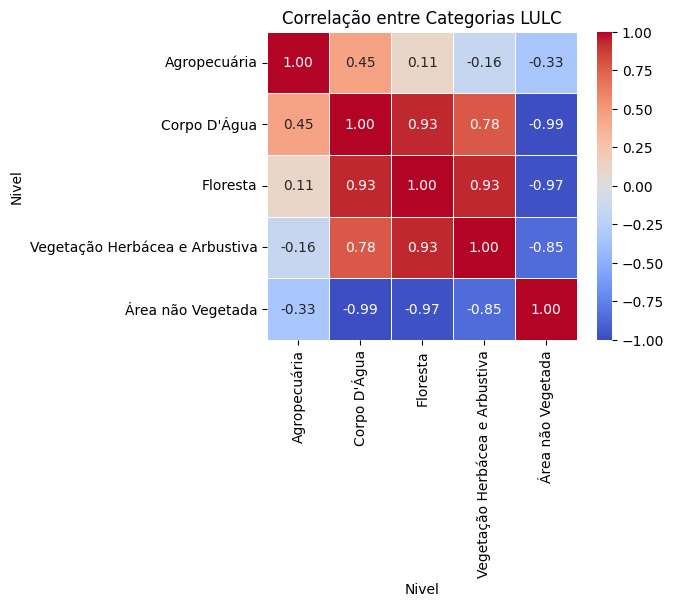

In [27]:
import seaborn as sns
plt.figure(figsize=(5, 4))
sns.heatmap(
    correlacao,
    annot=True,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    fmt=".2f"
)
plt.savefig('./graficos/lulc_paranoa_corr.png', dpi=300, bbox_inches='tight')  # PNG

plt.title("Correlação entre Categorias LULC")
plt.show()

In [28]:
lulc_data[lulc_data.ano.isin(["1985", "2024"])]

,Nivel,Color,ano,area_ha,area_percent
0,Floresta,#32a65e,1985,74168.91,67.12
39,Floresta,#32a65e,2024,62050.95,56.15
40,Vegetação Herbácea e Arbustiva,#ad975a,1985,3681.63,3.33
79,Vegetação Herbácea e Arbustiva,#ad975a,2024,2147.94,1.95
80,Agropecuária,#FFFFB2,1985,8458.11,7.66
119,Agropecuária,#FFFFB2,2024,10109.52,9.15
120,Área não Vegetada,#d4271e,1985,18878.76,17.09
159,Área não Vegetada,#d4271e,2024,31322.70,28.34
160,Corpo D'Água,#0000FF,1985,5317.29,4.81
199,Corpo D'Água,#0000FF,2024,4873.59,4.41


## PARA AS UNIDADES HIDROGRÁFICAS

In [46]:
import os
import geopandas as gpd
import pandas as pd

gdf_zonas = gpd.read_file("../input_data/bh_lago_paranoa_31983.geojson")  
zonas_nomes = gdf_zonas['uh_label'].tolist()  # Nomes das zonas

resultados = []
for arquivo in arquivos_lulc:
    ano = arquivo.split("_")[-1].replace(".geojson", "")
    caminho_lulc = os.path.join(pasta, arquivo)
    gdf_lulc = gpd.read_file(caminho_lulc)
    gdf_lulc = gdf_lulc.to_crs(gdf_zonas.crs)
    
    for idx_zona, zona in gdf_zonas.iterrows():
        lulc_na_zona = gpd.overlay(gdf_lulc, gpd.GeoDataFrame([zona]).set_crs(gdf_zonas.crs), how='intersection')
        for classe in lulc_na_zona['lucode'].unique(): 
            area_m2 = lulc_na_zona[lulc_na_zona['lucode'] == classe].area.sum()
            area_ha = area_m2 / 10_000 
            resultados.append({
                'ano': ano,
                'zona_id': zona['uh_label'],  
                'classe': classe,
                'area_ha': area_ha
            })


df_resultados_zonas = pd.DataFrame(resultados)

In [49]:
df_resultados_zonas.to_csv("df_resultados_zonas.csv", index = False)

In [3]:
df_resultados_zonas = pd.read_csv("df_resultados_zonas.csv")

In [4]:
df_resultados_zonas['area_percent'] = df_resultados_zonas.groupby(['zona_id', 'ano', 'zona_id'])['area_ha'].transform(
    lambda x: (x / x.sum()) * 100
).round(2)

In [5]:
df_resultados_zonas.zona_id.unique()

array(['UH 13  Riacho Fundo', 'UH 09  Lago Paranoá',
       'UH 17  Ribeirão do Gama', 'UH 07  Córrego Bananal',
       'UH 18  Ribeirão do Torto'], dtype=object)

In [12]:
df_resultados_zonas[(df_resultados_zonas.ano == 1985) & (df_resultados_zonas.zona_id == 'UH 13  Riacho Fundo')]

,ano,zona_id,classe,area_ha,area_percent
2114,1985,UH 13 Riacho Fundo,12,793.125000,3.95
2115,1985,UH 13 Riacho Fundo,11,189.286551,0.94
2116,1985,UH 13 Riacho Fundo,3,1848.776788,9.22
2117,1985,UH 13 Riacho Fundo,25,2649.688518,13.21
2118,1985,UH 13 Riacho Fundo,4,8091.320990,40.34
2119,1985,UH 13 Riacho Fundo,21,1641.554815,8.18
2120,1985,UH 13 Riacho Fundo,15,1147.463099,5.72
2121,1985,UH 13 Riacho Fundo,24,3456.756370,17.23
2122,1985,UH 13 Riacho Fundo,33,101.847616,0.51
2123,1985,UH 13 Riacho Fundo,39,104.493047,0.52


In [14]:
lulc_data_zonas = lulc_name[["Class_ID", "Nivel"]].merge(df_resultados_zonas, left_on = "Class_ID", right_on = "classe")[["Nivel", "zona_id", "ano", "area_ha", "area_percent"]]

In [15]:
print(sorted(lulc_data_zonas.Nivel.unique()))

['Agricultura', "Corpo D'Água", 'Floresta', 'Mosaico de Usos', 'Pastagem', 'Silvicultura', 'Vegetação Herbácea e Arbustiva', 'Área não Vegetada']


In [16]:
lulc_data_zonas['Nivel'] = lulc_data_zonas['Nivel'].replace(['Agricultura', 'Mosaico de Usos', 'Pastagem', 'Silvicultura'], 'Agropecuária')
lulc_data_zonas = lulc_data_zonas.groupby(['Nivel', "zona_id", 'ano'], as_index=False).agg({'area_ha': 'sum', 'area_percent': 'sum'})

In [20]:
lulc_data_zonas.zona_id.unique()

array(['UH 07  Córrego Bananal', 'UH 09  Lago Paranoá',
       'UH 13  Riacho Fundo', 'UH 17  Ribeirão do Gama',
       'UH 18  Ribeirão do Torto'], dtype=object)

In [27]:
lulc_data_zonas[(lulc_data_zonas.ano == 1985) & (lulc_data_zonas.zona_id == 'UH 18  Ribeirão do Torto')]

,Nivel,zona_id,ano,area_ha,area_percent
160,Agropecuária,UH 18 Ribeirão do Torto,1985,675.668832,2.75
360,Corpo D'Água,UH 18 Ribeirão do Torto,1985,790.950761,3.22
560,Floresta,UH 18 Ribeirão do Torto,1985,21497.584045,87.40
760,Vegetação Herbácea e Arbustiva,UH 18 Ribeirão do Torto,1985,613.395042,2.49
960,Área não Vegetada,UH 18 Ribeirão do Torto,1985,1017.662063,4.14


In [28]:
lulc_data_zonas[(lulc_data_zonas.ano == 2024) & (lulc_data_zonas.zona_id == 'UH 18  Ribeirão do Torto')]

,Nivel,zona_id,ano,area_ha,area_percent
199,Agropecuária,UH 18 Ribeirão do Torto,2024,1032.943040,4.20
399,Corpo D'Água,UH 18 Ribeirão do Torto,2024,756.392129,3.08
599,Floresta,UH 18 Ribeirão do Torto,2024,21013.398074,85.44
799,Vegetação Herbácea e Arbustiva,UH 18 Ribeirão do Torto,2024,515.145168,2.09
999,Área não Vegetada,UH 18 Ribeirão do Torto,2024,1277.382952,5.19


In [75]:
lulc_data_zonas = lulc_name[lulc_name.Level == 1][["Nivel", "Color"]].merge(lulc_data_zonas, on = "Nivel")

In [76]:
lulc_data_zonas[lulc_data_zonas.Nivel == "Floresta"]

,Nivel,Color,zona_id,ano,area_ha,area_percent
0,Floresta,#32a65e,UH 07 Córrego Bananal,1985,10661.592273,87.28
1,Floresta,#32a65e,UH 07 Córrego Bananal,1986,10647.015640,87.16
2,Floresta,#32a65e,UH 07 Córrego Bananal,1987,10635.878728,87.07
3,Floresta,#32a65e,UH 07 Córrego Bananal,1988,10658.753872,87.25
4,Floresta,#32a65e,UH 07 Córrego Bananal,1989,10703.166386,87.62
...,...,...,...,...,...,...
195,Floresta,#32a65e,UH 18 Ribeirão do Torto,2020,21059.483201,85.63
196,Floresta,#32a65e,UH 18 Ribeirão do Torto,2021,21067.660563,85.66
197,Floresta,#32a65e,UH 18 Ribeirão do Torto,2022,21073.103049,85.68
198,Floresta,#32a65e,UH 18 Ribeirão do Torto,2023,21042.125230,85.56


In [77]:
lulc_data_zonas.zona_id.unique()

array(['UH 07  Córrego Bananal', 'UH 09  Lago Paranoá',
       'UH 13  Riacho Fundo', 'UH 17  Ribeirão do Gama',
       'UH 18  Ribeirão do Torto'], dtype=object)

In [78]:
lulc_data_zonas[(lulc_data_zonas.ano == 1985) & (lulc_data_zonas.zona_id == 'UH 13  Riacho Fundo')]

,Nivel,Color,zona_id,ano,area_ha,area_percent
80,Floresta,#32a65e,UH 13 Riacho Fundo,1985,9940.097779,49.56
280,Vegetação Herbácea e Arbustiva,#ad975a,UH 13 Riacho Fundo,1985,982.411551,4.89
480,Agropecuária,#FFFFB2,UH 13 Riacho Fundo,1985,2926.534348,14.59
680,Área não Vegetada,#d4271e,UH 13 Riacho Fundo,1985,6106.444888,30.44
880,Corpo D'Água,#0000FF,UH 13 Riacho Fundo,1985,101.847616,0.51


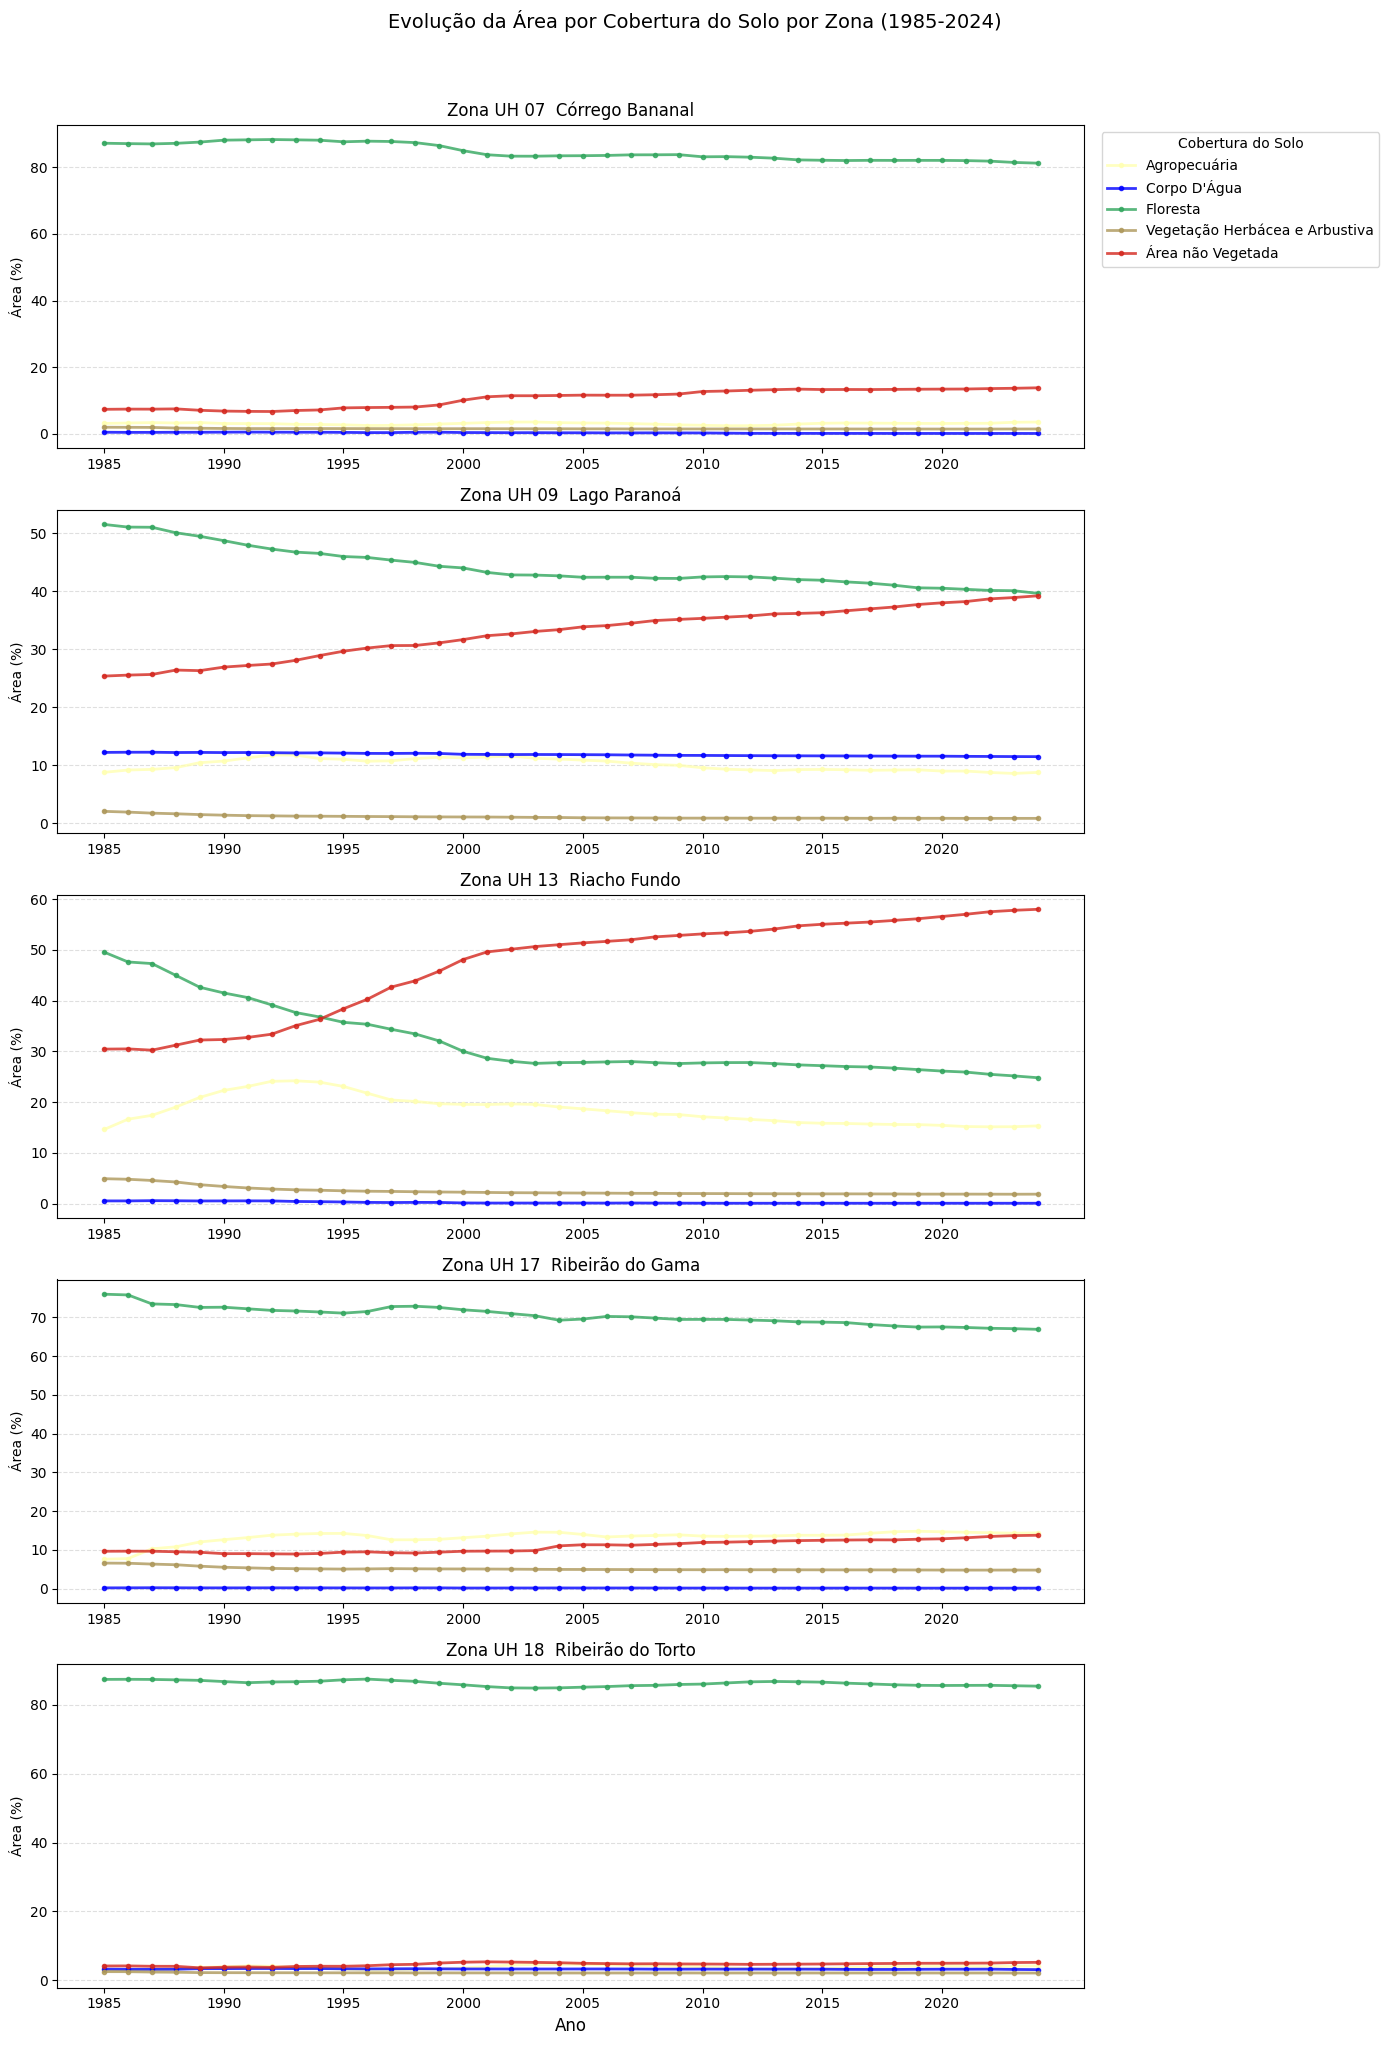

In [79]:
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(5, 1, figsize=(14, 20))

# Para cada zona (1 a 5)
for i, zona in enumerate(lulc_data_zonas['zona_id'].unique(), start=1):
    ax = axes[i-1]  # Índice começa em 0
    
    # Filtrar dados para a zona atual
    df_zona = lulc_data_zonas[lulc_data_zonas['zona_id'] == zona]
    df_plot = df_zona.groupby(['ano', 'Nivel', 'Color'])['area_percent'].mean().reset_index()
    
    # Plotar cada nível
    for nivel in df_plot['Nivel'].unique():
        subset = df_plot[df_plot['Nivel'] == nivel]
        cor = subset['Color'].iloc[0]
        ax.plot(subset['ano'], subset['area_percent'],
                marker='o',
                markersize=3,
                label=f'{nivel}',
                color=cor,
                alpha=0.8,
                linewidth=2)
    
    # Configurar cada subplot
    ax.set_title(f'Zona {zona}', fontsize=12)
    ax.set_ylabel('Área (%)', fontsize=10)
    ax.grid(True, axis='y', linestyle='--', alpha=0.4)
    ax.grid(False, axis='x')
    ax.set_xticks(df_plot['ano'].unique()[::5])  # Anos de 5 em 5
    
    # Adicionar legenda apenas no último subplot
    if i == 1:
        ax.legend(title='Cobertura do Solo', bbox_to_anchor=(1.01, 1), fontsize=10)

# Configurações gerais
plt.suptitle('Evolução da Área por Cobertura do Solo por Zona (1985-2024)', fontsize=14, y=1.02)
plt.xlabel('Ano', fontsize=12)
plt.tight_layout()
plt.show()

In [80]:
lulc_data_zonas['zona_id2'] = lulc_data_zonas.zona_id.apply(lambda row: "UH " + row.split("  ")[-1])
lulc_data_zonas

,Nivel,Color,zona_id,ano,area_ha,area_percent,zona_id2
0,Floresta,#32a65e,UH 07 Córrego Bananal,1985,10661.592273,87.28,UH Córrego Bananal
1,Floresta,#32a65e,UH 07 Córrego Bananal,1986,10647.015640,87.16,UH Córrego Bananal
2,Floresta,#32a65e,UH 07 Córrego Bananal,1987,10635.878728,87.07,UH Córrego Bananal
3,Floresta,#32a65e,UH 07 Córrego Bananal,1988,10658.753872,87.25,UH Córrego Bananal
4,Floresta,#32a65e,UH 07 Córrego Bananal,1989,10703.166386,87.62,UH Córrego Bananal
...,...,...,...,...,...,...,...
995,Corpo D'Água,#0000FF,UH 18 Ribeirão do Torto,2020,787.981212,3.20,UH Ribeirão do Torto
996,Corpo D'Água,#0000FF,UH 18 Ribeirão do Torto,2021,787.463309,3.20,UH Ribeirão do Torto
997,Corpo D'Água,#0000FF,UH 18 Ribeirão do Torto,2022,791.174426,3.22,UH Ribeirão do Torto
998,Corpo D'Água,#0000FF,UH 18 Ribeirão do Torto,2023,769.683963,3.13,UH Ribeirão do Torto


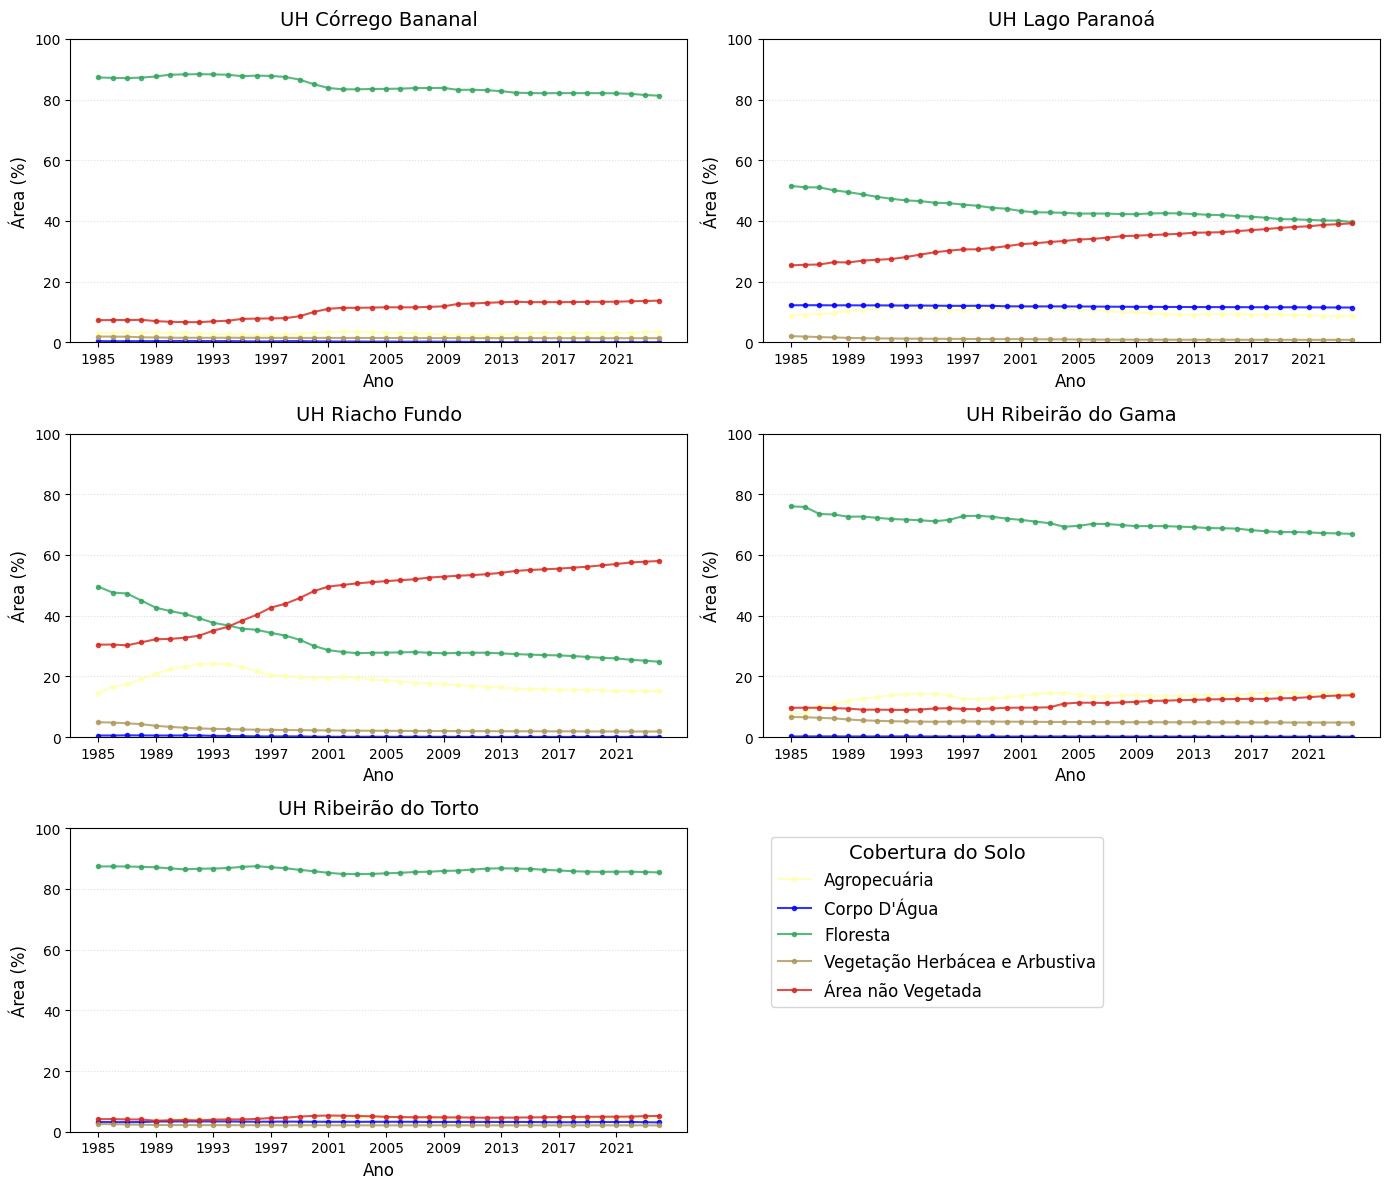

In [81]:

n_cols = 2
n_rows = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 12))

# Achatar o array de eixos para facilitar iteração
axes = axes.flatten()

# Para cada zona
for i, zona in enumerate(sorted(lulc_data_zonas['zona_id2'].unique())):
    ax = axes[i]
    
    # Filtrar dados para a zona atual
    df_zona = lulc_data_zonas[lulc_data_zonas['zona_id2'] == zona]
    df_plot = df_zona.groupby(['ano', 'Nivel', 'Color'])['area_percent'].mean().reset_index()
    
    # Plotar cada nível
    for nivel in df_plot['Nivel'].unique():
        subset = df_plot[df_plot['Nivel'] == nivel]
        cor = subset['Color'].iloc[0]
        ax.plot(subset['ano'], subset['area_percent'],
                marker='o',
                markersize=3,
                label=f'{nivel}',
                color=cor,
                alpha=0.8,
                linewidth=1.5)
    
    # Configurações do subplot
    ax.set_title(f'{zona}', fontsize=14, pad=10)
    ax.set_xlabel('Ano', fontsize=12)
    ax.set_ylabel('Área (%)', fontsize=12)
    ax.grid(True, axis='y', linestyle=':', alpha=0.4)
    ax.grid(False, axis='x')
    ax.set_xticks(df_plot['ano'].unique()[::4])  # Mostrar de 3 em 3 anos para melhor legibilidade
    ax.tick_params(axis="both", labelsize="10")
    ax.set_ylim(0, 100)
# **LEGENDA NO SEXTO QUADRANTE (índice 5)**
if len(axes) > 5:  # Verifica se existe o sexto quadrante
    # Coletar todos os handles e labels dos primeiros 5 gráficos
    handles, labels = [], []
    for i in range(5):
        h, l = axes[i].get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    
    # Remover duplicatas mantendo a ordem
    seen = set()
    unique_handles = []
    unique_labels = []
    for handle, label in zip(handles, labels):
        if label not in seen:
            seen.add(label)
            unique_handles.append(handle)
            unique_labels.append(label)
    
    # Criar legenda no sexto quadrante
    axes[5].axis('off')  # Desliga os eixos
    axes[5].legend(unique_handles, unique_labels, 
                   title='Cobertura do Solo', 
                   loc= "upper left",
                 #  bbox_to_anchor=(0.02, 0.98),
                   fontsize=12, 
                   title_fontsize=14,
                   frameon=True)

# Ajustes finais
#plt.suptitle('Evolução Temporal por Zona e Cobertura do Solo (1985-2024)',         fontsize=14,          y=1.02)
plt.tight_layout()

# Ocultar apenas o sétimo e oitavo eixos se existirem
for j in range(6, len(axes)):
    axes[j].axis('off')

plt.savefig('./graficos/lulc_paranoa_uh.png', dpi=1200, bbox_inches='tight')
plt.show()

In [82]:
lulc_data_zonas.zona_id.unique()

array(['UH 07  Córrego Bananal', 'UH 09  Lago Paranoá',
       'UH 13  Riacho Fundo', 'UH 17  Ribeirão do Gama',
       'UH 18  Ribeirão do Torto'], dtype=object)

Floresta
        Nivel   ano  area_percent  diferenca  diferenca_abs
120  Floresta  1985         76.01        NaN            NaN
        Nivel   ano  area_percent  diferenca  diferenca_abs
159  Floresta  2024         66.94      -0.17           0.17


,Nivel,ano,area_percent,diferenca,diferenca_abs
120,Floresta,1985,76.01,NaN,NaN
121,Floresta,1986,75.82,-0.19,0.19
122,Floresta,1987,73.50,-2.32,2.32
123,Floresta,1988,73.33,-0.17,0.17
124,Floresta,1989,72.60,-0.73,0.73
125,Floresta,1990,72.65,0.05,0.05
126,Floresta,1991,72.24,-0.41,0.41
127,Floresta,1992,71.83,-0.41,0.41
128,Floresta,1993,71.67,-0.16,0.16
129,Floresta,1994,71.42,-0.25,0.25


      ano  area_percent  diferenca
122  1987         73.50      -2.32
132  1997         72.82       1.28
139  2004         69.30      -1.16
124  1989         72.60      -0.73
141  2006         70.27       0.68
Vegetação Herbácea e Arbustiva
                              Nivel   ano  area_percent  diferenca  \
320  Vegetação Herbácea e Arbustiva  1985          6.59        NaN   

     diferenca_abs  
320            NaN  
                              Nivel   ano  area_percent  diferenca  \
359  Vegetação Herbácea e Arbustiva  2024          4.78      -0.01   

     diferenca_abs  
359           0.01  


,Nivel,ano,area_percent,diferenca,diferenca_abs
320,Vegetação Herbácea e Arbustiva,1985,6.59,NaN,NaN
321,Vegetação Herbácea e Arbustiva,1986,6.55,-0.04,0.04
322,Vegetação Herbácea e Arbustiva,1987,6.33,-0.22,0.22
323,Vegetação Herbácea e Arbustiva,1988,6.16,-0.17,0.17
324,Vegetação Herbácea e Arbustiva,1989,5.79,-0.37,0.37
325,Vegetação Herbácea e Arbustiva,1990,5.51,-0.28,0.28
326,Vegetação Herbácea e Arbustiva,1991,5.36,-0.15,0.15
327,Vegetação Herbácea e Arbustiva,1992,5.21,-0.15,0.15
328,Vegetação Herbácea e Arbustiva,1993,5.14,-0.07,0.07
329,Vegetação Herbácea e Arbustiva,1994,5.09,-0.05,0.05


      ano  area_percent  diferenca
324  1989          5.79      -0.37
325  1990          5.51      -0.28
322  1987          6.33      -0.22
323  1988          6.16      -0.17
327  1992          5.21      -0.15
Agropecuária
            Nivel   ano  area_percent  diferenca  diferenca_abs
554  Agropecuária  2019          14.8       0.12           0.12
            Nivel   ano  area_percent  diferenca  diferenca_abs
520  Agropecuária  1985          7.58        NaN            NaN


,Nivel,ano,area_percent,diferenca,diferenca_abs
520,Agropecuária,1985,7.58,NaN,NaN
521,Agropecuária,1986,7.76,0.18,0.18
522,Agropecuária,1987,10.28,2.52,2.52
523,Agropecuária,1988,10.79,0.51,0.51
524,Agropecuária,1989,12.04,1.25,1.25
525,Agropecuária,1990,12.63,0.59,0.59
526,Agropecuária,1991,13.17,0.54,0.54
527,Agropecuária,1992,13.79,0.62,0.62
528,Agropecuária,1993,14.06,0.27,0.27
529,Agropecuária,1994,14.23,0.17,0.17


      ano  area_percent  diferenca
522  1987         10.28       2.52
524  1989         12.04       1.25
532  1997         12.60      -1.10
541  2006         13.33      -0.65
527  1992         13.79       0.62
Área não Vegetada
                 Nivel   ano  area_percent  diferenca  diferenca_abs
759  Área não Vegetada  2024         13.77       0.09           0.09
                 Nivel   ano  area_percent  diferenca  diferenca_abs
728  Área não Vegetada  1993          8.93      -0.04           0.04


,Nivel,ano,area_percent,diferenca,diferenca_abs
720,Área não Vegetada,1985,9.64,NaN,NaN
721,Área não Vegetada,1986,9.66,0.02,0.02
722,Área não Vegetada,1987,9.65,-0.01,0.01
723,Área não Vegetada,1988,9.51,-0.14,0.14
724,Área não Vegetada,1989,9.38,-0.13,0.13
725,Área não Vegetada,1990,9.02,-0.36,0.36
726,Área não Vegetada,1991,9.03,0.01,0.01
727,Área não Vegetada,1992,8.97,-0.06,0.06
728,Área não Vegetada,1993,8.93,-0.04,0.04
729,Área não Vegetada,1994,9.07,0.14,0.14


      ano  area_percent  diferenca
739  2004         11.03       1.22
725  1990          9.02      -0.36
730  1995          9.42       0.35
757  2022         13.46       0.34
745  2010         11.91       0.31
Corpo D'Água
            Nivel   ano  area_percent  diferenca  diferenca_abs
922  Corpo D'Água  1987          0.22       0.02           0.02
            Nivel   ano  area_percent  diferenca  diferenca_abs
956  Corpo D'Água  2021          0.12        0.0            0.0


,Nivel,ano,area_percent,diferenca,diferenca_abs
920,Corpo D'Água,1985,0.19,NaN,NaN
921,Corpo D'Água,1986,0.20,0.01,0.01
922,Corpo D'Água,1987,0.22,0.02,0.02
923,Corpo D'Água,1988,0.21,-0.01,0.01
924,Corpo D'Água,1989,0.19,-0.02,0.02
925,Corpo D'Água,1990,0.19,0.00,0.00
926,Corpo D'Água,1991,0.19,0.00,0.00
927,Corpo D'Água,1992,0.20,0.01,0.01
928,Corpo D'Água,1993,0.20,0.00,0.00
929,Corpo D'Água,1994,0.19,-0.01,0.01


      ano  area_percent  diferenca
935  2000          0.15      -0.04
922  1987          0.22       0.02
924  1989          0.19      -0.02
933  1998          0.19       0.02
921  1986          0.20       0.01
Matriz de Correlação:


Nivel,Agropecuária,Corpo D'Água,Floresta,Vegetação Herbácea e Arbustiva,Área não Vegetada
Nivel,,,,,
Agropecuária,1.000000,-0.600484,-0.814377,-0.933487,0.445611
Corpo D'Água,-0.600484,1.000000,0.880670,0.744423,-0.899182
Floresta,-0.814377,0.880670,1.000000,0.838250,-0.878747
Vegetação Herbácea e Arbustiva,-0.933487,0.744423,0.838250,1.000000,-0.570768
Área não Vegetada,0.445611,-0.899182,-0.878747,-0.570768,1.000000


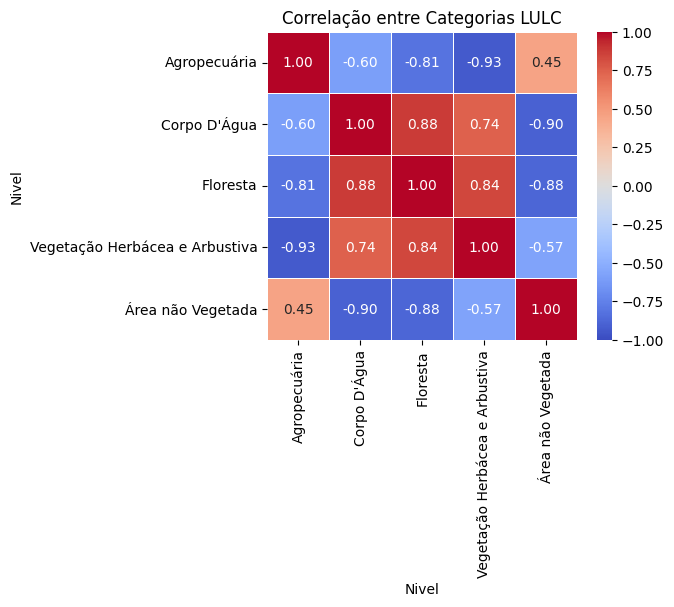

In [83]:
lulc_data = lulc_data_zonas[lulc_data_zonas.zona_id == 'UH 17  Ribeirão do Gama']
for nivel in lulc_data.Nivel.unique():
    print(nivel)
    filt = lulc_data[lulc_data.Nivel == nivel][["Nivel", "ano", "area_percent"]].sort_values("ano")
    filt["diferenca"] = filt["area_percent"].diff()
    filt["diferenca_abs"] = filt["diferenca"].abs()
    print(filt.sort_values("area_percent", ascending = False).head(1))
    print(filt.sort_values("area_percent").head(1))
    display(filt) #.sort_values("diferenca"))
    maiores_diferencas = filt.nlargest(5, "diferenca_abs")
    print(maiores_diferencas[["ano", "area_percent", "diferenca"]])

    lulc_pivot = lulc_data.pivot(index='ano', columns='Nivel', values='area_percent')
    correlacao = lulc_pivot.corr()
    
print("Matriz de Correlação:")
display(correlacao)
plt.figure(figsize=(5, 4))
sns.heatmap(
    correlacao,
    annot=True,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    fmt=".2f"
)

plt.title("Correlação entre Categorias LULC")
plt.show()

In [ ]:
lulc_data_zonas[lulc_data_zonas.ano.isin([1985, 2024])][["Nivel", "zona_id", "ano", "area_percent"]]#.to_excel("./graficos/lulc_uh.xlsx")